In [203]:
import os
import pandas as pd
import numpy as np
import geopandas as gdp

import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir("/Users/nguyenluong/wb_internship/Data")

# Grabbing Best Model

In [104]:
# Load grid search results
results = pd.read_csv('output/binary_results.csv')
results_sorted = results[results['features'] == 'ALL_FEATURES'].sort_values('score', ascending=False)
results_sorted.head(3)

,Unnamed: 0,regressor,params,features,accuracy_score,recall_score,precision_score,nonpoverty_class,poverty_class,recall_nonpoverty,recall_poverty,recall_diff,score
80,80,AdaBoostClassifier,"{'n_estimators': 10, 'base_estimator': Decisio...",ALL_FEATURES,0.758621,0.726444,0.707101,"{'precision': 0.797752808988764, 'recall': 0.7...","{'precision': 0.7071005917159763, 'recall': 0....",0.781938,0.726444,0.055495,0.726444
76,76,AdaBoostClassifier,"{'n_estimators': 10, 'base_estimator': Decisio...",ALL_FEATURES,0.736909,0.753799,0.664879,"{'precision': 0.802439024390244, 'recall': 0.7...","{'precision': 0.6648793565683646, 'recall': 0....",0.724670,0.753799,0.029130,0.724670
56,56,AdaBoostClassifier,"{'n_estimators': 5, 'base_estimator': Decision...",ALL_FEATURES,0.750958,0.720365,0.697059,"{'precision': 0.7923250564334086, 'recall': 0....","{'precision': 0.6970588235294117, 'recall': 0....",0.773128,0.720365,0.052763,0.720365


In [99]:
# Load best regressor by accuracy
df_bestmodel = results_sorted.iloc[0]
best_regressor = pd.read_pickle(f'output/{df_bestmodel["regressor"]}_trained.pkl')

# Grab best model
best_model = None
for x in best_regressor:
    if df_bestmodel['params'] in x.params and df_bestmodel['features'] in x.features:
        best_model = x
best_model

Trained AdaBoostClassifier on feature set ALL_FEATURES with params {'n_estimators': 10, 'base_estimator': DecisionTreeClassifier(max_depth=15), 'random_state': 0}

In [100]:
# Merge manipulated bisp data and fully prepped data to get geometry for predictions
original = pd.read_pickle('saved_objects/gdf_bisp.pkl')[['uid', 'geometry']]
fully_prepped = pd.read_pickle('saved_objects/fully_prepped.pkl')

df = original.merge(fully_prepped, left_on='uid', right_on='uid')
df = df.rename(columns={'in_poverty': 'true_label'})
df.head(3)

,uid,geometry,true_label,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,...,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
0,104989,POINT (72.70222 33.82792),0,666.513693,654.914636,278.161786,313.877143,4237.741336,63.020461,1851.007324,...,-345.045746,-3.774210,-405.881775,124.655396,128.065933,-311.599670,186.155182,-82.589050,-215.191452,289.295654
1,100389,POINT (72.70272 33.82786),0,707.590360,691.084276,290.853957,301.885996,4213.933117,61.828224,1892.079096,...,-345.045746,-3.774210,-405.881775,124.655396,128.065933,-311.599670,186.155182,-82.589050,-215.191452,289.295654
2,101236,POINT (72.70361 33.82756),0,794.660657,748.261101,256.930948,256.773891,4151.273547,35.532442,1958.231310,...,-113.222961,151.570343,-603.139587,227.736145,80.859642,-530.808044,-54.274338,-121.480789,-166.718674,39.535019


In [101]:
# Run best model and get predictions
from sklearn.ensemble import AdaBoostClassifier

X = df.iloc[:,3:]
df['pred_label'] = best_model.regressor.predict(X)

df.head(3)

,uid,geometry,true_label,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,...,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pred_label
0,104989,POINT (72.70222 33.82792),0,666.513693,654.914636,278.161786,313.877143,4237.741336,63.020461,1851.007324,...,-3.774210,-405.881775,124.655396,128.065933,-311.599670,186.155182,-82.589050,-215.191452,289.295654,0
1,100389,POINT (72.70272 33.82786),0,707.590360,691.084276,290.853957,301.885996,4213.933117,61.828224,1892.079096,...,-3.774210,-405.881775,124.655396,128.065933,-311.599670,186.155182,-82.589050,-215.191452,289.295654,0
2,101236,POINT (72.70361 33.82756),0,794.660657,748.261101,256.930948,256.773891,4151.273547,35.532442,1958.231310,...,151.570343,-603.139587,227.736145,80.859642,-530.808044,-54.274338,-121.480789,-166.718674,39.535019,0


# Fig1. Eval Metrics for Grid Search and Whole Data

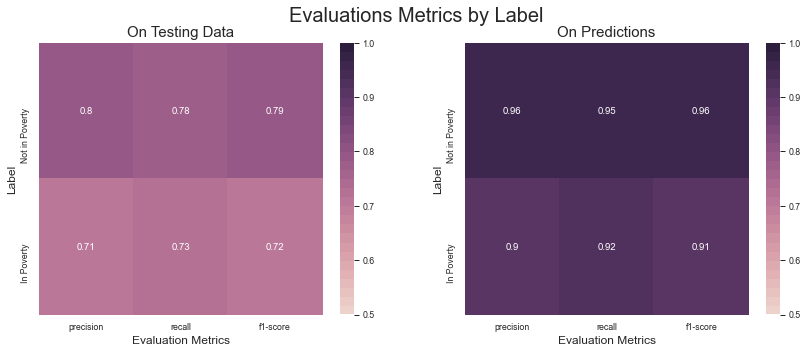

In [357]:
import ast 
from sklearn.metrics import classification_report

# Grid Search
cr = {'Not in Poverty': ast.literal_eval(df_bestmodel['nonpoverty_class']),
      'In Poverty': ast.literal_eval(df_bestmodel['poverty_class'])}
df_cr = pd.DataFrame.from_dict({i: cr[i] for i in cr.keys()}, orient='index')
df_cr = df_cr.drop(columns=['support'])

# Whole data
cr1 = classification_report(df['true_label'], df['pred_label'], target_names=['Not in Poverty','In Poverty'],
                           output_dict=True)
df_cr1 = pd.DataFrame.from_dict({k: cr1[k] for k in ('Not in Poverty','In Poverty')}).T
df_cr1 = df_cr1.drop(columns=['support'])

# Plot
f, (ax0, ax1) = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)
plt.suptitle('Evaluations Metrics by Label', fontsize=20)
sns.set(context="paper")

sns.heatmap(df_cr, annot=True, cmap=sns.cubehelix_palette(30), ax=ax0, vmin=0.5, vmax=1)
ax0.set_xlabel('Evaluation Metrics', fontsize=12)
ax0.set_ylabel('Label', fontsize=12)
ax0.set_title('On Testing Data', fontsize=15)

sns.heatmap(df_cr1, annot=True, cmap=sns.cubehelix_palette(30), ax=ax1, vmin=0.5, vmax=1)
ax1.set_xlabel('Evaluation Metrics', fontsize=12)
ax1.set_ylabel('Label', fontsize=12)
ax1.set_title('On Predictions', fontsize=15)

plt.savefig('grid_eval_metrics.png', bbox_inches='tight')
plt.show()

# Fig2. Confusion Matrix 

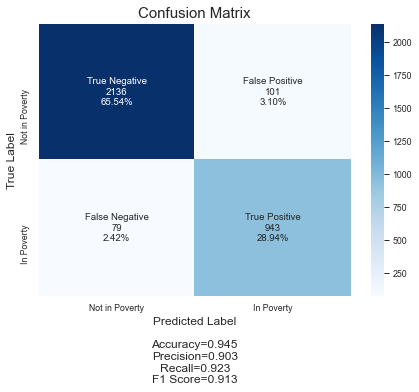

In [361]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score)

true, pred = df['true_label'].copy(), df['pred_label'].copy()

a = accuracy_score(true, pred)
r = recall_score(true, pred)
p = precision_score(true, pred)

# Compute confusion matrix and define classes/names
cm = confusion_matrix(true, pred)

# Format box text
classes = ['Not in Poverty', 'In Poverty']
names = ['True Negative','False Positive','False Negative', 'True Positive']
labels = ["{}\n".format(x) for x in names]
counts = ["{0:0.0f}\n".format(x) for x in cm.flatten()]
percentages = ["{0:.2%}".format(x) for x in cm.flatten()/np.sum(cm)]
box_text = [f'{x}{y}{z}'.strip() for x, y, z in zip(labels, counts, percentages)]
box_text = np.asarray(box_text).reshape(cm.shape)

# Format stats 
a = accuracy_score(true, pred)
r = recall_score(true, pred)
p = precision_score(true, pred)
f1 = f1_score(true, pred)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                a, p, r, f1)

f, ax = plt.subplots(figsize=(7, 5))
sns.set(context="paper")
ax = sns.heatmap(cm, annot=box_text, fmt="", cmap="Blues", xticklabels=classes, yticklabels=classes)
ax.set_xlabel(('Predicted Label' + stats_text), fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=15)

plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# Fig3. Feature Importances

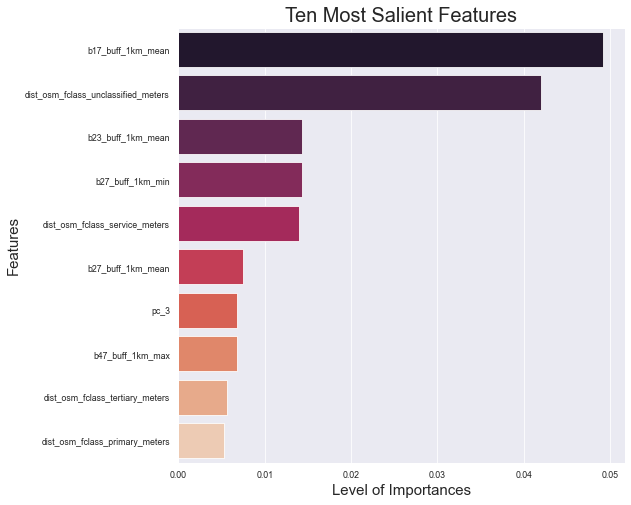

In [364]:
# FEATURE IMPORTANCES
sns.set(style="darkgrid", context="paper")

# Get importances
importances = pd.Series(best_model.regressor.feature_importances_).sort_values(ascending=False)
importances = importances.replace(np.inf, np.nan)
importances = importances.dropna()[0:10]

# Sort in descending order
indices = importances.index.values

# Sort the labels in a corresponding fashion
labels = X.columns.values[indices]

# Plot
f, ax = plt.subplots(figsize=(8, 8))

ax = sns.barplot(x=importances, y=labels, palette="rocket")
ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Level of Importances", fontsize=15)
ax.set_title('Ten Most Salient Features', fontsize=20)

plt.savefig('feature_importances.png', bbox_inches='tight')
plt.show()

# Fig4. Side-by-Side Map

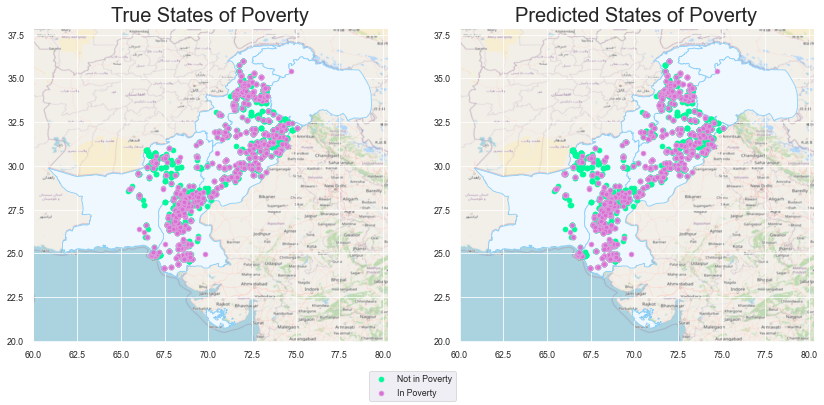

In [383]:
import contextily as ctx
import matplotlib.cm as cm
boundaries = gdp.read_file('stanford-qx809sm7397-geojson.json')

fig, (ax0, ax1) = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)

# True Labels 
boundaries.plot(ax=ax0, color='ALICEBLUE', edgecolor='LIGHTSKYBLUE')
df[df['true_label']==0].plot(column='true_label', color='MEDIUMSPRINGGREEN', edgecolor='MEDIUMSPRINGGREEN', ax=ax0)
df[df['true_label']==1].plot(column='true_label', color='ORCHID', edgecolor='PLUM', ax=ax0)
ctx.add_basemap(ax0, crs='epsg:4326', url=ctx.sources.OSM_C)
ax0.set_title('True States of Poverty', fontsize=20)

# Predictions
boundaries.plot(ax=ax1, color='ALICEBLUE', edgecolor='LIGHTSKYBLUE')
df[df['pred_label']==0].plot(column='pred_label', color='MEDIUMSPRINGGREEN', edgecolor='MEDIUMSPRINGGREEN', ax=ax1)
df[df['pred_label']==1].plot(column='pred_label', color='ORCHID', edgecolor='PLUM', ax=ax1)
ctx.add_basemap(ax1, crs='epsg:4326', url=ctx.sources.OSM_C)
ax1.set_title('Predicted States of Poverty', fontsize=20)

fig.legend(labels=['Not in Poverty', 'In Poverty'], loc='lower center')
plt.savefig('map.png', bbox_inches='tight')
plt.show()

In [21]:
# Creating interactive map
boundaries = gdp.read_file('stanford-qx809sm7397-geojson.json')
gdf = pd.read_pickle('saved_objects/gdf_bisp.pkl')

m = folium.Map(location=[30.3753, 69.3451], zoom_start=5.40)

style = {'fillColor': 'LIGHTSKYBLUE', 'lineColor': 'LIGHTBLUE'}
folium.GeoJson(boundaries,
               name='boundaries_geojson',
               style_function=lambda x: style
              ).add_to(m)

binary_poverty = list(gdf.in_poverty)
points = list(gdf.geometry)
for score, point in zip(binary_poverty, points):
    if score == 1:
        folium.vector_layers.CircleMarker(location=[point.y, point.x],
                                          radius=2,
                                          color='ORCHID',
                                          fill_color='ORCHID').add_to(m)
    else:
        folium.vector_layers.CircleMarker(location=[point.y, point.x],
                                          radius=2,
                                          color='YELLOWGREEN',
                                          fill_color='YELLOWGREEN').add_to(m)
m.save("true_poverty_map.html")

In [22]:
m